<a href="https://colab.research.google.com/github/drumalv/Click-Bait-NLP/blob/main/ClickBait.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install

In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"

In [ ]:
!pip install -q -U tf-models-official==2.7.0

In [ ]:
!pip install -U tfds-nightly

In [ ]:
import os
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
from official.nlp import optimization
import numpy as np

tf.get_logger().setLevel('ERROR')

### Ingesta de datos y preprocesado

Primero cargo los datos

In [ ]:
df_train=pd.read_csv("/content/drive/MyDrive/prueba newtral/train/webis_train.csv")
df_test=pd.read_csv("/content/drive/MyDrive/prueba newtral/test/webis_test.csv")

nos quedamos con los tweets y la variable truthClass como target.

In [ ]:
df_test = df_test[['postText', 'truthClass']]
df_train = df_train[['postText', 'truthClass']]
df_train.head()

,postText,truthClass
0,UK’s response to modern slavery leaving victim...,no-clickbait
1,this is good,clickbait
2,"The ""forgotten"" Trump roast: Relive his brutal...",no-clickbait
3,Meet the happiest #dog in the world!,clickbait
4,Tokyo's subway is shut down amid fears over an...,no-clickbait


In [ ]:
df_train.shape

(19538, 2)

In [ ]:
df_test.shape

(18979, 2)

Primero de todo, cabe destacar que el problema de detección de clickbait es un problema de clasificación binaria. Para ello, cambiamos mapeamos la variable target de la siguiente manera:

*   no-clickbait = 0 
*   clickbait = 1



In [ ]:
df_test['truthClass']=df_test['truthClass'].replace({'no-clickbait': 0, 'clickbait': 1})
df_train['truthClass']=df_train['truthClass'].replace({'no-clickbait': 0, 'clickbait': 1})
df_train.head()

,postText,truthClass
0,UK’s response to modern slavery leaving victim...,0
1,this is good,1
2,"The ""forgotten"" Trump roast: Relive his brutal...",0
3,Meet the happiest #dog in the world!,1
4,Tokyo's subway is shut down amid fears over an...,0


In [ ]:
df_test.head()

,postText,truthClass
0,Johnny Manziel on Browns' No. 1 pick Myles Gar...,0
1,Fabio: California Is a 'Mess' Because of Liber...,0
2,"""He's been huge for us this year, man.""",1
3,New Bears quarterback Mitchell Trubisky was gr...,0
4,It's not enough to let employees work flexible...,0


In [ ]:
X_train=np.array(df_train['postText']).astype(str)
y_train=np.array(df_train['truthClass']).astype(np.float32)

X_test=np.array(df_test['postText']).astype(str)
y_test=np.array(df_test['truthClass']).astype(np.float32)

### Análisis descriptivo

In [ ]:
df_train_=pd.read_csv("/content/drive/MyDrive/prueba newtral/train/webis_train.csv")
df_test_=pd.read_csv("/content/drive/MyDrive/prueba newtral/test/webis_test.csv")
df=pd.concat([df_train_,df_test_], ignore_index=True)
df['truthClass']=df['truthClass'].replace({'no-clickbait': 0, 'clickbait': 1})

Podemos ver como tenemos 38397 tweets. Pero no todos son únicos. Existe uno repetido 29 veces. "Quote of the day" es el tweet más repetido y tiene sentido por que es un tweet recurrente en muchas cuentas.

In [ ]:
df['postText'].describe()

count                 38397
unique                37016
top       Quote of the day:
freq                     29
Name: postText, dtype: object

Obtenemos diagrama de frecuencia de palabras, para que sea más visual, voy a generar la nube de palabras.

In [ ]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud

In [ ]:
df['postText']=np.array(df['postText']).astype(str)
df['truthClass']=np.array(df['truthClass']).astype(np.float32)

In [ ]:
def nubePalabras(words):
  #Convert word list to a single string
  clean_words_string = " ".join(words)

  #generating the wordcloud
  wordcloud = WordCloud(background_color="white").generate(clean_words_string)

  #plot the wordcloud
  plt.figure(figsize = (12, 12))
  plt.imshow(wordcloud)

  #to remove the axis value
  plt.axis("off")
  plt.show()

In [ ]:
words = []
for i in range(df.shape[0]):
  words.append(df['postText'][i].split())
words = [word for tweet_words in words for word in tweet_words]

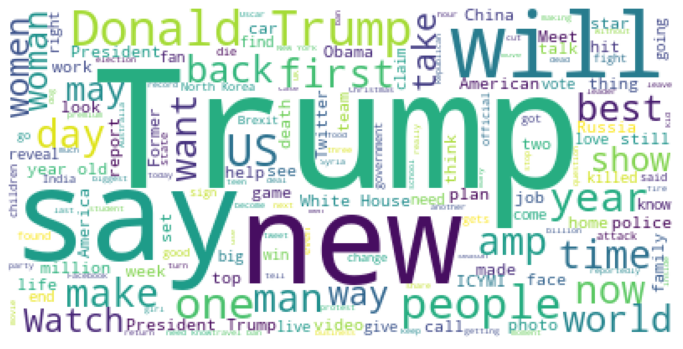

In [ ]:
nubePalabras(words)

Como ya sabíamos podemos deducir que el tema clave de los tweets es Donal Trump. Ahora voy a generar las nubes de palabras diferenciando por la variable target.

**Click-bait**

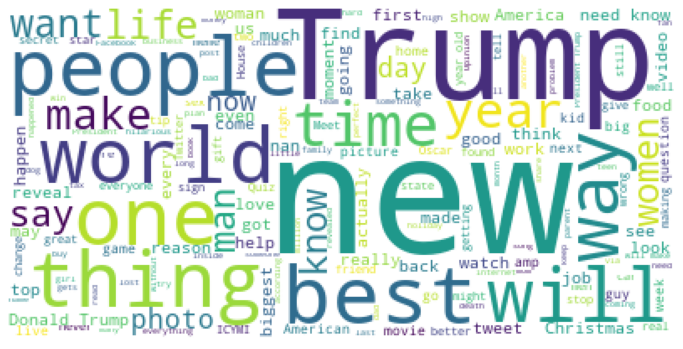

In [ ]:
words_clickbait = []
for i in range(df.shape[0]):
  if df['truthClass'][i]==1:
    words_clickbait.append(df['postText'][i].split())
words_clickbait = [word for tweet_words in words_clickbait for word in tweet_words]

nubePalabras(words_clickbait)

No Click-bait

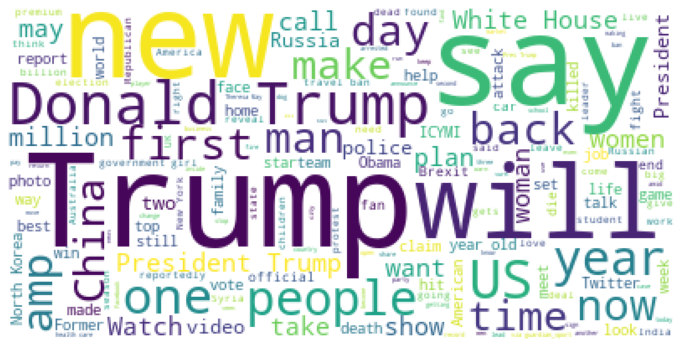

In [ ]:
words_no_clickbait = []
for i in range(df.shape[0]):
  if df['truthClass'][i]==0:
    words_no_clickbait.append(df['postText'][i].split())
words_no_clickbait = [word for tweet_words in words_no_clickbait for word in tweet_words]

nubePalabras(words_no_clickbait)

Podemos observar que las palabra **new** y **people** toman más importancia en el click-bait. 

### Configuración TPU

Siguiendo las recomendaciones de la librería tensorflow, configuramos la TPU

In [ ]:
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

In [ ]:
if os.environ['COLAB_TPU_ADDR']:
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')
elif tf.config.list_physical_devices('GPU'):
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
else:
  raise ValueError('Running on CPU is not recommended.')

Using TPU


### Fine Tuning Modelo BERT

In [ ]:
import tensorflow_hub as hub

Eligo el modelo small bert por ser el más simple para un primer acercamiento a la solución.

In [ ]:
#@title Elección del tipo de modelo BERT

bert_model_name = "small_bert/bert_en_uncased_L-2_H-512_A-8" #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_uncased_L-24_H-1024_A-16", "bert_en_wwm_uncased_L-24_H-1024_A-16", "bert_en_cased_L-12_H-768_A-12", "bert_en_cased_L-24_H-1024_A-16", "bert_en_wwm_cased_L-24_H-1024_A-16", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "albert_en_large", "albert_en_xlarge", "albert_en_xxlarge", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base", "talking-heads_large"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_cased_L-24_H-1024_A-16/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_large/2',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_xlarge/2',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_xxlarge/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print('BERT model selected           :', tfhub_handle_encoder)
print('Preprocessing model auto-selected:', tfhub_handle_preprocess)

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


Seleccionamos el preprocesamiento de los datos para el modelo elegido.

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Comprobamos que funciona con nuestros datos

In [ ]:
df_train['postText'][0]

'UK’s response to modern slavery leaving victims destitute while abusers go free'

In [ ]:
text_test = [df_train['postText'][0]]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2866 1521 1055 3433 2000 2715 8864 2975 5694 4078 3775]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


Se puede observar que tokeniza bien el tweet, por lo que proseguimos generando el modelo.

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

Definimos un modelo simple que se compone primero del preprocesado, segundo del modelo BERT, luego de una capa de dropout para tratar el overfitting y finalmente una capa densa para obtener un entero. En esta última capa seleccionamos la función de activación sigmoide por su idoneidad ante problemas de clasificación binaria.

In [ ]:
def build_classifier_model(tfhub_handle_preprocess,tfhub_handle_encoder):
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

comprobamos que el modelo ejecuta correctamente para el tweet que hemos probado antes.

In [ ]:
classifier_model = build_classifier_model(tfhub_handle_preprocess,tfhub_handle_encoder)
bert_raw_result = classifier_model(tf.constant(text_test))
print(bert_raw_result)

tf.Tensor([[0.36002237]], shape=(1, 1), dtype=float32)


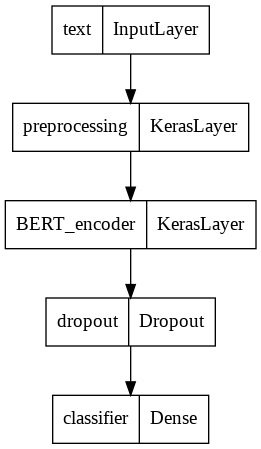

In [ ]:
tf.keras.utils.plot_model(classifier_model)

Dado que este es un problema de clasificación binaria y el modelo de salida da una probabilidad (una capa de una sola unidad). Vamos a utilizar la función de pérdida BinaryCrossentropy y nos vamos a centrar en optimizar el Accuracy.

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()

Finalmente, en cuanto a los hiperparámetros, voy a usar los que se usaron para entrenar el modelo BERT (aportados por la librería tensorflow en su documentación).


In [ ]:
epochs = 5
steps_per_epoch = len(X_train)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Una vez creado el modelo, estamos en disposición de entrenarlo para el problema concreto que estudiamos en este notebook.

In [ ]:
history = classifier_model.fit(x=X_train, y=y_train,
                               validation_split=0.2,
                               epochs=epochs)

Epoch 1/5
489/489 [==============================] - 185s 368ms/step - loss: 0.5541 - binary_accuracy: 0.7254 - val_loss: 0.4417 - val_binary_accuracy: 0.8027
Epoch 2/5
489/489 [==============================] - 180s 367ms/step - loss: 0.4279 - binary_accuracy: 0.8113 - val_loss: 0.3722 - val_binary_accuracy: 0.8327
Epoch 3/5
489/489 [==============================] - 182s 371ms/step - loss: 0.3813 - binary_accuracy: 0.8347 - val_loss: 0.3564 - val_binary_accuracy: 0.8457
Epoch 4/5
489/489 [==============================] - 181s 370ms/step - loss: 0.3569 - binary_accuracy: 0.8464 - val_loss: 0.3484 - val_binary_accuracy: 0.8506
Epoch 5/5
489/489 [==============================] - 180s 368ms/step - loss: 0.3405 - binary_accuracy: 0.8524 - val_loss: 0.3443 - val_binary_accuracy: 0.8544


### Evaluación del modelo

Para esta tarea, usaremos el conjunto de test aportado.

In [ ]:
loss, accuracy = classifier_model.evaluate(X_test,y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

594/594 [==============================] - 73s 123ms/step - loss: 0.3210 - binary_accuracy: 0.8589
Loss: 0.32095521688461304
Accuracy: 0.8588966727256775


Podemos observar que el modelo ha abstraido bien al conjunto de test. El resultado de accuracy y de la función de pérdida son muy similares a los obtenidos en el entrenamiento.

### Comparativa con otros modelos

Voy a comparar el modelos SmallBert y con el modelo ALBert

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
def modeloSmallBert(epochs,init_lr):

  model=build_classifier_model('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3','https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1')


  steps_per_epoch = len(X_train)
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = int(0.1*num_train_steps)

  optimizer = optimization.create_optimizer(init_lr=init_lr,
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type='adamw')
  
  loss = tf.keras.losses.BinaryCrossentropy()
  metrics = tf.metrics.BinaryAccuracy()

  model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
  
  return model



In [ ]:
def modeloALBert(epochs,init_lr):

  model=build_classifier_model('https://tfhub.dev/tensorflow/albert_en_preprocess/3','https://tfhub.dev/tensorflow/albert_en_base/2')

  steps_per_epoch = len(X_train)
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = int(0.1*num_train_steps)

  optimizer = optimization.create_optimizer(init_lr=init_lr,
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type='adamw')
  
  loss = tf.keras.losses.BinaryCrossentropy()
  metrics = tf.metrics.BinaryAccuracy()

  model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
  
  return model

In [ ]:
epochs=1
models=[modeloSmallBert(epochs,3e-5),modeloALBert(epochs,3e-5)]
models_names = ["Modelos Small Bert", "Modelo ALBert"]

for i in range(len(models)):
  print(models_names[i])
  models[i].fit(x=X_train, y=y_train,validation_split=0.2,epochs=epochs)

Modelos Small Bert
489/489 [==============================] - 185s 368ms/step - loss: 0.5013 - binary_accuracy: 0.7538 - val_loss: 0.3749 - val_binary_accuracy: 0.8314
Modelo ALBert
489/489 [==============================] - 1702s 3s/step - loss: 0.4470 - binary_accuracy: 0.7778 - val_loss: 0.3360 - val_binary_accuracy: 0.8544


De esta forma podríamos comparar entre modelos o entre el mismo modelo con distintos hiperparámetros. Debido a la complejidad computacional que conlleva esta tarea, solo he podido probar dos modelos y con una única época de entrenamiento.

No se pueden sacar conclusiones de esta prueba, pero queda patente una de las formas para comparar modelos en el proceso de búsqueda de la mejor solución que podamos encontrar.

### Comentarios finales

Comentar que con poco esfuerzo hemos conseguido con el modelo BERT resultados razonablemente buenos. Por lo que cabría esperar que aplicando más esfuerzo en la búsqueda de hiperparámetros y aumentando el número de modelos; se consiga una solución muy razonable.

En cuanto a los datos, cabría pensar que el preprocesamiento del modelo no está pensado para tratar los hastags y los emoticonos. De esta forma, sería bueno idear otra tokenización específica para la jerga lingüistica que tienen los tweets.